第三方库导入

In [11]:
import utils
import re,os,shutil,random

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime
from scipy.signal import wiener

灰度共生矩阵和纹理特征

In [12]:

#  """计算灰度共生矩阵"""
def fast_glcm(img, vmin=0, vmax=255, levels=8, kernel_size=5, distance=1.0, angle=0.0):
    # '''
    # Parameters
    # ----------
    # img: array_like, shape=(h,w), dtype=np.uint8
    #     input image
    # vmin: int
    #     minimum value of input image
    # vmax: int
    #     maximum value of input image
    # levels: int
    #     number of grey-levels of GLCM
    # kernel_size: int
    #     Patch size to calculate GLCM around the target pixel
    # distance: float
    #     pixel pair distance offsets [pixel] (1.0, 2.0, and etc.)
    # angle: float
    #     pixel pair angles [degree] (0.0, 30.0, 45.0, 90.0, and etc.)
    # Returns
    # -------
    # Grey-level co-occurrence matrix for each pixels
    # shape = (levels, levels, h, w)
    # '''
    
    # digitize
    bins = np.linspace(vmin, vmax+1, levels+1)
    gl1 = np.digitize(img, bins) - 1
 
    # make shifted image
    dx = distance*np.cos(np.deg2rad(angle))
    dy = distance*np.sin(np.deg2rad(-angle))
    mat = np.array([[1.0,0.0,-dx], [0.0,1.0,-dy]], dtype=np.float32)
    h,w = img.shape
    gl2 = cv2.warpAffine(gl1, mat, (w,h), flags=cv2.INTER_NEAREST,
                         borderMode=cv2.BORDER_REPLICATE)
 
    # make glcm
    glcm = np.zeros((levels, levels, h, w), dtype=np.uint8)
    for i in range(levels):
        for j in range(levels):
            mask = ((gl1==i) & (gl2==j))
            glcm[i,j, mask] = 1
 
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    for i in range(levels):
        for j in range(levels):
            glcm[i,j] = cv2.filter2D(glcm[i,j], -1, kernel)
 
    glcm = glcm.astype(np.float32)
    return glcm
 
# """计算纹理特征"""
def fast_textural_features(glcm, vmin=0, vmax=255, levels=8, kernel_size=5):
    _,_,h,w = glcm.shape
    # 计算最大值
    max_  = np.max(glcm, axis=(0,1))
    # 计算熵
    pnorm = glcm / np.sum(glcm, axis=(0,1)) + 1./kernel_size**2
    ent  = np.sum(-pnorm * np.log(pnorm), axis=(0,1))
    # 均值/标准差/对比度/相异性/同质性/角二阶距
    mean,std2,cont,diss,homo,asm = [np.zeros((h,w), dtype=np.float32) for x in range(6)]
    for i in range(levels):
        for j in range(levels):
            mean += glcm[i,j] * i / (levels)**2 # 计算均值
            cont += glcm[i,j] * (i-j)**2 # 计算对比度
            diss += glcm[i,j] * np.abs(i-j) # 计算相异性
            homo += glcm[i,j] / (1.+(i-j)**2) # 计算同质性
            asm  += glcm[i,j]**2 # 计算角二阶距
    # 计算能量
    ene = np.sqrt(asm)
    # 计算标准差
    for i in range(levels):
        for j in range(levels):
            std2 += (glcm[i,j] * i - mean)**2
    std = np.sqrt(std2)   
    
    return [max_,ent,mean,std,cont,diss,homo,asm,ene]
 
 
if __name__ == '__main__':
    
    img = cv2.imread("../My_image/group_tape_stripping_numbers/4_20_0/4_0_20_0.jpg",0) # 以灰度读取
    glcm = fast_glcm(img, vmin=0, vmax=255, levels=8, kernel_size=5, distance=1.0, angle=0.0) # 计算共生矩阵
    textural = fast_textural_features(glcm, vmin=0, vmax=255, levels=8, kernel_size=5)
 
 

[array([[ 25.,  25.,  25., ...,  25.,  25.,  25.],
       [ 25.,  25.,  25., ...,  25.,  25.,  25.],
       [ 25.,  25.,  25., ...,  25.,  25.,  25.],
       ..., 
       [ 25.,  25.,  25., ...,  25.,  25.,  25.],
       [ 25.,  25.,  25., ...,  25.,  25.,  25.],
       [ 25.,  25.,  25., ...,  25.,  25.,  25.]], dtype=float32), array([[ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075],
       [ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075],
       [ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075],
       ..., 
       [ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075],
       [ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075],
       [ 8.07078075,  8.07078075,  8.07078075, ...,  8.07078075,
         8.07078075,  8.07078075]], dtype=float32), array([[ 0.390625,  0.390625,  0.390625

图像处理函数

In [15]:


# sobel算子特征提取
def sobel_feature(img):
    # Apply the Sobel filter
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    # Combine the results to get the final image
    sobel = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)
    return sobel

# 拉普拉斯算子特征提取
def laplacian_feature(img):
    # Apply the Laplacian filter
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    return laplacian

# Canny算子特征提取
def canny_feature(img):
    # Apply the Canny filter
    canny = cv2.Canny(img, 100, 200)
    return canny

# 高斯滤波
def gaussian_filtered(img):
    # Apply Gaussian filter
    gaussian_filtered = cv2.GaussianBlur(img, (5, 5), 0)
    return gaussian_filtered

# 中值滤波
def median_filtered(img):
    # Apply median filter
    median_filtered = cv2.medianBlur(img, 5)
    return median_filtered

# Wiener滤波
def wiener_filtered(img):
    # Apply Wiener filter
    wiener_filtered = wiener(img, (3, 3))
    wiener_filtered = np.uint8(wiener_filtered / wiener_filtered.max() * 255)
    return wiener_filtered


# cv2.waitKey(0)
# cv2.destroyAllWindows()

维纳滤波

直方图均衡化

In [10]:

# Load the image
img = cv2.imread("../My_image/group_tape_stripping_numbers/3_20_90/3_0_20_90.jpg", cv2.IMREAD_GRAYSCALE)

# Perform histogram equalization
equalized = cv2.equalizeHist(img)

# Show the original and equalized images
cv2.imshow("Original", img)
cv2.imshow("Equalized", equalized)
cv2.waitKey(0)
cv2.destroyAllWindows()



Python调用Matlab文件

In [13]:
# Python调用matlab文件
import matlab.engine
eng = matlab.engine.start_matlab()

eng.hellomatlab(nargout=0)


GLCM python代码

In [ ]:

import cv2
import math

#定义最大灰度级数
gray_level = 16

def maxGrayLevel(img):
    max_gray_level=0
    (height,width)=img.shape
    print ("图像的高宽分别为：height,width",height,width)
    for y in range(height):
        for x in range(width):
            if img[y][x] > max_gray_level:
                max_gray_level = img[y][x]
    print("max_gray_level:",max_gray_level)
    return max_gray_level+1

def getGlcm(input,d_x,d_y):
    srcdata=input.copy()
    ret=[[0.0 for i in range(gray_level)] for j in range(gray_level)]
    (height,width) = input.shape

    max_gray_level=maxGrayLevel(input)
    #若灰度级数大于gray_level，则将图像的灰度级缩小至gray_level，减小灰度共生矩阵的大小
    if max_gray_level > gray_level:
        for j in range(height):
            for i in range(width):
                srcdata[j][i] = srcdata[j][i]*gray_level / max_gray_level

    for j in range(height-d_y):
        for i in range(width-d_x):
            rows = srcdata[j][i]
            cols = srcdata[j + d_y][i+d_x]
            ret[rows][cols]+=1.0

    for i in range(gray_level):
        for j in range(gray_level):
            ret[i][j]/=float(height*width)

    return ret

def feature_computer(p):
    #con:对比度反应了图像的清晰度和纹理的沟纹深浅。纹理越清晰反差越大对比度也就越大。
    #eng:熵（Entropy, ENT）度量了图像包含信息量的随机性，表现了图像的复杂程度。当共生矩阵中所有值均相等或者像素值表现出最大的随机性时，熵最大。
    #agm:角二阶矩（能量），图像灰度分布均匀程度和纹理粗细的度量。当图像纹理均一规则时，能量值较大；反之灰度共生矩阵的元素值相近，能量值较小。
    #idm:反差分矩阵又称逆方差，反映了纹理的清晰程度和规则程度，纹理清晰、规律性较强、易于描述的，值较大。
    Con=0.0
    Eng=0.0
    Asm=0.0
    Idm=0.0
    for i in range(gray_level):
        for j in range(gray_level):
            Con+=(i-j)*(i-j)*p[i][j]
            Asm+=p[i][j]*p[i][j]
            Idm+=p[i][j]/(1+(i-j)*(i-j))
            if p[i][j]>0.0:
                Eng+=p[i][j]*math.log(p[i][j])
    return Asm,Con,-Eng,Idm

def test(image_name):
    img = cv2.imread(image_name)
    try:
        img_shape=img.shape
    except:
        print ('imread error')
        return

    #这里如果用‘/’会报错TypeError: integer argument expected, got float
    #其实主要的错误是因为 因为cv2.resize内的参数是要求为整数
    img=cv2.resize(img,(img_shape[1]//2,img_shape[0]//2),interpolation=cv2.INTER_CUBIC)

    img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    glcm_0=getGlcm(img_gray, 1,0)
    #glcm_1=getGlcm(src_gray, 0,1)
    #glcm_2=getGlcm(src_gray, 1,1)
    #glcm_3=getGlcm(src_gray, -1,1)
    # print(glcm_0)

    asm,con,eng,idm=feature_computer(glcm_0)

    return [asm,con,eng,idm]

if __name__=='__main__':
    filePath = "../My_image/group_tape_stripping_numbers/3_20_90"
    name = os.listdir(filePath)

    for i in name:
        print("这是"+i)
        path = filePath + "/" + i
        result = test(path)
        print(result)

运行

这是mat文件
          0         1         2
0  0.660802  0.667866  0.952717
1  0.617583  0.687287  0.951396
2  0.521496  0.662483  0.937891
3  0.685828  0.713903  0.961309
4  0.658163  0.632746  0.941406
              0         1         2
count  5.000000  5.000000  5.000000
mean   0.628774  0.672857  0.948944
std    0.064766  0.030143  0.009383
min    0.521496  0.632746  0.937891
25%    0.617583  0.662483  0.941406
50%    0.658163  0.667866  0.951396
75%    0.660802  0.687287  0.952717
max    0.685828  0.713903  0.961309


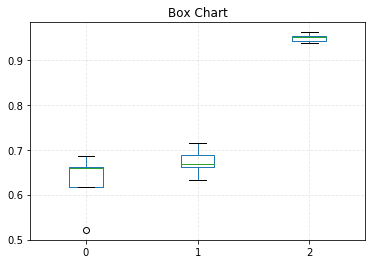

In [10]:


# 读取mat文件
import scipy.io as sio
import numpy as np
import os
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt


# 读取mat文件
def read_mat(path):
    data = sio.loadmat(path)
    return data

print("这是mat文件")
mat_path = "../Result_Images/GLCM/GLCMFeatures_sum.mat"
mat_data = read_mat(mat_path)


df = pd.DataFrame(mat_data['GLCMFeatures_sum'][0:5,1:5])
print(df)
print(df.describe())
df.plot.box(title="Box Chart")
plt.grid(linestyle="--", alpha=0.3)
plt.show()
